In [1]:
from _plotly_future_ import v4_subplots
from plotly.subplots import make_subplots

import itertools

import pandas as pd
pd.set_option("display.max_rows", 1500)
pd.set_option("display.max_columns", 1000)
import numpy as np
import scipy as scp
import scipy.stats as ss
import sklearn.metrics as sm

from scipy.integrate import quad
import matplotlib.pyplot as plt

import scipy.special as scps
from statsmodels.graphics.gofplots import qqplot
from scipy.linalg import cholesky
from functools import partial
from scipy.optimize import minimize, brute, fmin
from IPython.display import display
import sympy; sympy.init_printing()
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

from plotly.offline import init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)


def display_matrix(m):
    display(sympy.Matrix(m))

$$
\phi(u,t) = E[exp(iu \operatorname{log}(S_t))|S_0, v_0] \\
\qquad \ = \operatorname{exp}(iu(\operatorname{log}S_0 + (r-q)t)) \\
\qquad \;  \times \operatorname{exp}(\theta\kappa\sigma^{-2}((\kappa - \rho \sigma u i -d)t - 2 \operatorname{log}((1-g \operatorname{e}^{-dt})/(1-g)))) \\
\qquad \; \times \operatorname{exp}(v_0 \sigma^{-2}(\kappa - \rho \sigma u i -d)(1-\operatorname{e}^{-dt})/(1-g\operatorname{e}^{-dt}))
$$

where
$$
d = ((\rho \sigma u i - \kappa)^2 - \theta^2(-iu-u^2))^{\frac{1}{2}} \\
g = (\kappa - \rho \sigma u i - d) / (\kappa - \rho \sigma u i + d)
$$

notes: $\mu=r-q$ in the codes below

In [2]:
def cf_Heston_schoutens(u, S0, t, mu, v0, kappa, theta, rho, sigma):
    """
    Heston characteristic function as proposed by Schoutens (2004)
    """
    phi = kappa - sigma*rho*u*1j
    d  = np.sqrt( ((-phi)**2) - ((sigma**2) * (-1j*u - u**2 )) )
    g  = (phi-d)/(phi+d)
    
    cf = np.exp((1j*u)*(np.log(S0)+mu*t)) * \
         np.exp((kappa*theta)/(sigma**2) * ( (phi-d)*t - 2*np.log( (1-g*np.exp(-d*t))/(1-g) ))) *\
         np.exp((v0/sigma**2)*(phi-d) * (1-np.exp(-d*t))/(1-g*np.exp(-d*t)) )
    return cf

$
C(K,T) = \frac{\operatorname{exp}(-\alpha \operatorname{log}(K))}{\pi}
\int^{+\infty}_{0} \operatorname{exp}(-iv\operatorname{log}(K))\xi(v)dv
$

where

$
\xi(v) = \frac{\operatorname{exp}(-rT)E[\operatorname{exp}(i(v-(\alpha+1)i) \operatorname{log}(S_T))]}{\alpha^2 + \alpha - v^2 + i(2\alpha + 1)v}\\
\ \ \ \  \; = \frac{\operatorname{exp}(-rT)\phi(v-(\alpha+1)i,T)}
{\alpha^2 + \alpha - v^2 + i(2\alpha + 1)v}
$

In [3]:
def xi(u, alpha, S0, t, mu, v0, kappa, theta, rho, sigma):
    cf = cf_Heston_schoutens(u - (alpha+1)*1j,
                             S0, t, mu, v0, kappa, theta, rho, sigma)
    numerator = np.exp(-mu*t)*cf
    denominator = alpha**2 + alpha - u**2 + 1j*(2*alpha+1)*u
    return numerator/denominator

def call_price(alpha, S0, K, t, mu, par):
    v0, kappa, theta, rho, sigma = par
    multiplier = np.exp(-alpha*np.log(K))/np.pi
    integrand = lambda u: (np.exp(-1j*u*np.log(K)))*xi(u, alpha, S0, t, mu, v0, kappa, theta, rho, sigma)
    return multiplier * quad(integrand, limit=10000, a=0, b=np.inf)[0] 

In [4]:
v0 = 0.013681                                        # spot variance
rho = -0.620100                                         # correlation coefficient
kappa = 1.605179                                          # mean reversion coefficient
theta = 0.053318                                        # long-term mean of the variance
sigma = 0.590506                                     # (Vol of Vol) - Volatility of instantaneous variance

mu = 0.00                                         # drift
t = T = 24/12                                             # Time to mat
r = 0.00                                          # risk-free rate
K = 1                                            # Stike  
S0 = 1                                          # spot stock price 

alpha = 0.75
par = v0, kappa, theta, rho, sigma
call_price(alpha, S0, K, t, mu, par)

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/scipy/integrate/quadpack.py:450: ComplexWarning:

Casting complex values to real discards the imaginary part



In [5]:
%%time
Strikes = [.8,.85,.9,.95,.975,1,1.025,1.05,1.1,1.15,1.2]
Terms = [1/12,2/12,3/12,6/12,12/12,18/12,24/12]
call_prices = np.zeros([len(Terms),len(Strikes)])

for c, K in enumerate(Strikes):
    for r, t in enumerate(Terms):
        result = call_price(alpha, S0, K, t, mu, par)
        call_prices[r][c] = result
#         print(result, T)

CPU times: user 517 ms, sys: 2.65 ms, total: 520 ms
Wall time: 519 ms


In [6]:
M = np.array(list(itertools.product(Strikes, Terms)))#.reshape((len(Strikes), len(Terms)))

In [7]:
%%time
call_price_eval = partial(call_price, 
                          alpha=alpha, S0=S0, mu=mu, v0=v0, 
                          kappa=kappa, theta=theta, rho=rho, sigma=sigma)
testresult = np.apply_along_axis(lambda x: call_price_eval(K=x[0], t=x[1]), 1, M)

TypeError: call_price() got an unexpected keyword argument 'v0'

In [8]:
def lossfunction(par, BSprice, S0, mu):
    Strikes = [.8,.85,.9,.95,.975,1,1.025,1.05,1.1,1.15,1.2]
    Terms = [1/12,2/12,3/12,6/12,12/12,18/12,24/12]
    HSprice = np.zeros([len(Terms),len(Strikes)])

    for c, K in enumerate(Strikes):
        for r, t in enumerate(Terms):
            result = call_price(alpha, S0, K, t, mu, par)
            HSprice[r][c] = result
            
    return np.mean(np.abs(BSprice.values - HSprice))

In [11]:
#prices derived from implied volatilities, assuming S0 = 1 and r = q = 0

BSprice = '''
0.2000 0.2000 0.2005 0.2048 0.2151 0.2260 0.2372
0.1500 0.1502 0.1522 0.1579 0.1718 0.1852 0.1984
0.1004 0.1021 0.1050 0.1136 0.1315 0.1473 0.1624
0.0523 0.0566 0.0612 0.0735 0.0951 0.1130 0.1297
0.0305 0.0364 0.0421 0.0560 0.0788 0.0975 0.1147
0.0132 0.0199 0.0262 0.0407 0.0641 0.0831 0.1007
0.0038 0.0089 0.0144 0.0281 0.0509 0.0701 0.0878
0.0008 0.0033 0.0070 0.0184 0.0396 0.0583 0.0759
0.0001 0.0004 0.0015 0.0069 0.0224 0.0390 0.0555
0.0000 0.0000 0.0005 0.0025 0.0117 0.0249 0.0394
0.0000 0.0000 0.0001 0.0010 0.0059 0.0154 0.0272
'''
BSprice = BSprice.replace('\n',' ').split(' ')[1:-1]

BSprice = pd.DataFrame(np.array(BSprice).reshape(11,7).T,
             index = ['1 month','2 months','3 months', '6 months', '1 year', '1.5 years', '2 years'] ,
   columns=['80%', '85%', '90%','95%','97.5%','100%', '102.50%','105%','110%','115%','120%'])


BSprice = BSprice.astype('float')

In [12]:
# lossfunction2opt = partial(lossfunction, BSprice=BSprice, S0=S0, mu=mu)
# init_par = np.random.uniform(size=5)
# res = minimize(lossfunction2opt, init_par, method='nelder-mead',
#                options={'xtol': 1e-4, 'disp': True})

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning:

overflow encountered in exp

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning:

invalid value encountered in cdouble_scalars

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: IntegrationWarning:

The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning:

invalid value encountered in multiply



KeyboardInterrupt: 

In [264]:
lossfunction2opt(par=par)

In [14]:
par = v0, kappa, theta, rho, sigma

p0 = brute(lossfunction2opt,
           ((0.01, 0.031, 0.01),  # v0
               (2.5, 10.6, 5.0),  # kappa_v
            (0.01, 0.041, 0.01),  # theta_v
            (-0.75, 0.01, 0.25),  # rho
            (0.05, 0.251, 0.1))   # sigma_v
            ,finish=None, workers=6)

In [15]:
p0

array([ 0.01,  2.5 ,  0.04, -0.75,  0.25])

In [17]:
opt = fmin(lossfunction2opt, p0,
           xtol=0.001, ftol=0.001,
           maxiter=1000, maxfun=50)

In [18]:
lossfunction2opt(opt)

from Mayer paper:
V0 kappa theta rho sigma
0.013681 1.605179 0.053318 −0.620100 0.590506

In [19]:
opt

array([ 0.01277087,  1.79809331,  0.04495749, -0.91204852,  0.30023209])

In [303]:
Strikes = [.8,.85,.9,.95,.975,1,1.025,1.05,1.1,1.15,1.2]
Terms = [1/12,2/12,3/12,6/12,12/12,18/12,24/12]
call_prices = np.zeros([len(Terms),len(Strikes)])

for c, K in enumerate(Strikes):
    for r, t in enumerate(Terms):
        result = call_price(alpha, S0, K, t, mu, par=opt)
        call_prices[r][c] = result

In [304]:
call_prices_df = pd.DataFrame(call_prices,
    index = ['1 mo','2 mo','3 mo', '6 mo', '1 yr', '1.5 yr', '2 yr'] ,
   columns=['80%', '85%', '90%','95%','97.5%','100%', '102.50%','105%','110%','115%','120%'])
call_prices_df = call_prices_df.apply(lambda x: round(x,4))
call_prices_df

,80%,85%,90%,95%,97.5%,100%,102.50%,105%,110%,115%,120%
1 mo,0.2000,0.1500,0.1002,0.0519,0.0304,0.0135,0.0035,0.0003,0.0000,0.0000,0.0000
2 mo,0.2000,0.1503,0.1014,0.0560,0.0363,0.0202,0.0088,0.0025,0.0000,0.0000,0.0000
3 mo,0.2003,0.1511,0.1036,0.0604,0.0417,0.0260,0.0139,0.0059,0.0004,0.0000,0.0000
6 mo,0.2028,0.1561,0.1122,0.0730,0.0558,0.0407,0.0280,0.0179,0.0053,0.0009,0.0001
1 yr,0.2119,0.1692,0.1297,0.0945,0.0788,0.0645,0.0516,0.0404,0.0226,0.0110,0.0045
1.5 yr,0.2220,0.1821,0.1453,0.1123,0.0974,0.0836,0.0709,0.0594,0.0401,0.0254,0.0149
2 yr,0.2318,0.1939,0.1590,0.1275,0.1132,0.0998,0.0873,0.0759,0.0559,0.0397,0.0271


In [224]:
%%time
np.sum(np.abs(BSprice.values.T.flatten() - testresult))

CPU times: user 100 µs, sys: 9 µs, total: 109 µs
Wall time: 105 µs


In [236]:
np.mean(np.abs(np.round(testresult, 4)-BSprice.values.T.flatten()))

In [192]:
testresult = testresult.reshape((len(Strikes), len(Terms))).T
testresult = pd.DataFrame(testresult ,
     index = ['1 mo','2 mo','3 mo', '6 mo', '1 yr', '1.5 yr', '2 yr'] ,
   columns = ['80%', '85%', '90%','95%','97.5%','100%', '102.50%','105%','110%','115%','120%'])

In [193]:
testresult

,80%,85%,90%,95%,97.5%,100%,102.50%,105%,110%,115%,120%
1 mo,0.200005,5.814291e-04,0.057060,0.000003,0.013212,0.113837,0.002026,0.063667,0.185293,0.039129,0.114558
2 mo,0.150051,1.040797e-05,0.036959,0.200842,0.005871,0.073541,0.000742,0.050404,0.147573,0.025023,0.100631
3 mo,0.100401,1.661787e-07,0.020097,0.152105,0.001029,0.055645,0.214915,0.038964,0.113384,0.015530,0.087732
6 mo,0.052606,2.704079e-09,0.008427,0.104991,0.000192,0.039870,0.171816,0.021786,0.097850,0.236398,0.075898
1 yr,0.031148,2.002069e-01,0.002815,0.061387,0.000039,0.026782,0.131499,0.011465,0.083484,0.197819,0.055500
1.5 yr,0.013735,1.507290e-01,0.000275,0.042065,0.204562,0.016841,0.095001,0.005936,0.070372,0.162019,0.039411
2 yr,0.003570,1.023555e-01,0.000028,0.025562,0.158030,0.005876,0.078594,0.225852,0.058585,0.129468,0.027301


In [109]:
call_prices_df = pd.DataFrame(call_prices,
    index = ['1 mo','2 mo','3 mo', '6 mo', '1 yr', '1.5 yr', '2 yr'] ,
   columns=['80%', '85%', '90%','95%','97.5%','100%', '102.50%','105%','110%','115%','120%'])
call_prices_df = call_prices_df.apply(lambda x: round(x,4))
call_prices_df

,80%,85%,90%,95%,97.5%,100%,102.50%,105%,110%,115%,120%
1 mo,0.2000,0.1501,0.1004,0.0526,0.0311,0.0137,0.0036,0.0006,0.0000,0.0000,0.0000
2 mo,0.2002,0.1507,0.1024,0.0571,0.0370,0.0201,0.0084,0.0028,0.0003,0.0000,0.0000
3 mo,0.2008,0.1521,0.1050,0.0614,0.0421,0.0256,0.0132,0.0059,0.0010,0.0002,0.0000
6 mo,0.2046,0.1580,0.1138,0.0735,0.0556,0.0399,0.0268,0.0168,0.0059,0.0020,0.0007
1 yr,0.2149,0.1718,0.1315,0.0950,0.0786,0.0637,0.0504,0.0390,0.0218,0.0115,0.0059
1.5 yr,0.2259,0.1853,0.1476,0.1134,0.0978,0.0835,0.0704,0.0586,0.0391,0.0250,0.0155
2 yr,0.2364,0.1978,0.1620,0.1295,0.1146,0.1006,0.0877,0.0759,0.0555,0.0394,0.0273


In [100]:
BSprice

,0.800,0.850,0.900,0.950,0.975,1.000,1.025,1.050,1.100,1.150,1.200
0.083333,0.2000,0.1500,0.1004,0.0523,0.0305,0.0132,0.0038,0.0008,0.0001,0.0000,0.0000
0.166667,0.2000,0.1502,0.1021,0.0566,0.0364,0.0199,0.0089,0.0033,0.0004,0.0000,0.0000
0.250000,0.2005,0.1522,0.1050,0.0612,0.0421,0.0262,0.0144,0.0070,0.0015,0.0005,0.0001
0.500000,0.2048,0.1579,0.1136,0.0735,0.0560,0.0407,0.0281,0.0184,0.0069,0.0025,0.0010
1.000000,0.2151,0.1718,0.1315,0.0951,0.0788,0.0641,0.0509,0.0396,0.0224,0.0117,0.0059
1.500000,0.2260,0.1852,0.1473,0.1130,0.0975,0.0831,0.0701,0.0583,0.0390,0.0249,0.0154
2.000000,0.2372,0.1984,0.1624,0.1297,0.1147,0.1007,0.0878,0.0759,0.0555,0.0394,0.0272


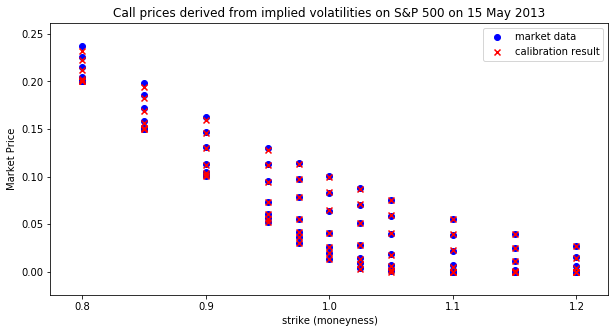

In [309]:
def unpivot(frame):
    N, K = frame.shape
    data = {'Z': frame.to_numpy().ravel('F'),
            'Y': np.asarray(frame.columns).repeat(N),
            'X': np.tile(np.asarray(frame.index), K)}
    return pd.DataFrame(data, columns=['X', 'Y', 'Z'])

BSprice_toplot = BSprice
BSprice_toplot.index = [1/12,2/12,3/12,6/12,12/12,18/12,24/12]
BSprice_toplot.columns =[.8, .85, .9,.95,.975,1, 
                                   1.025, 1.05, 1.10 , 1.15 ,1.20]
BSprice_toplot = BSprice_toplot.astype('float')
BSprice_toplot = unpivot(BSprice_toplot)
BSprice_toplot.columns = ['time to maturity', 'strike', 'price']

call_prices_df_toplot = call_prices_df
call_prices_df_toplot.index = [1/12,2/12,3/12,6/12,12/12,18/12,24/12]
call_prices_df_toplot.columns =[.8, .85, .9,.95,.975,1, 
                                   1.025, 1.05, 1.10 , 1.15 ,1.20]
call_prices_df_toplot = call_prices_df_toplot.astype('float')
call_prices_df_toplot = unpivot(call_prices_df_toplot)
call_prices_df_toplot.columns = ['time to maturity', 'strike', 'price']

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
ax.scatter(BSprice_toplot['strike'], 
           BSprice_toplot['price'], marker='o', color='b', label = 'market data')

ax.scatter(call_prices_df_toplot['strike'], 
           call_prices_df_toplot['price'], marker='x', color='r', label = 'calibration result')

ax.set(xlabel='strike (moneyness)', ylabel='Market Price', 
       title='Call prices derived from implied volatilities on S&P 500 on 15 May 2013')

ax.legend()

[Text(69.0, 0.5, 'Time to Maturity'),
 Text(0.5, 38.15454545454545, 'strike (moneyness)'),
 Text(0.5, 1, 'Relative Error')]

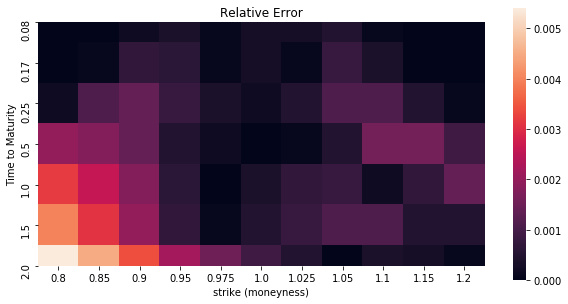

In [327]:
fig = plt.figure(figsize=(10,5))
error = np.abs(BSprice.values - call_prices_df)
error.index = np.round(error.index, 2)
ax = sns.heatmap(error, square=True)
ax.set(xlabel='strike (moneyness)', ylabel='Time to Maturity', 
       title='Relative Error')

In [130]:
BSprice

,0.800,0.850,0.900,0.950,0.975,1.000,1.025,1.050,1.100,1.150,1.200
0.083333,0.2000,0.1500,0.1004,0.0523,0.0305,0.0132,0.0038,0.0008,0.0001,0.0000,0.0000
0.166667,0.2000,0.1502,0.1021,0.0566,0.0364,0.0199,0.0089,0.0033,0.0004,0.0000,0.0000
0.250000,0.2005,0.1522,0.1050,0.0612,0.0421,0.0262,0.0144,0.0070,0.0015,0.0005,0.0001
0.500000,0.2048,0.1579,0.1136,0.0735,0.0560,0.0407,0.0281,0.0184,0.0069,0.0025,0.0010
1.000000,0.2151,0.1718,0.1315,0.0951,0.0788,0.0641,0.0509,0.0396,0.0224,0.0117,0.0059
1.500000,0.2260,0.1852,0.1473,0.1130,0.0975,0.0831,0.0701,0.0583,0.0390,0.0249,0.0154
2.000000,0.2372,0.1984,0.1624,0.1297,0.1147,0.1007,0.0878,0.0759,0.0555,0.0394,0.0272


In [126]:
call_prices_df

,80%,85%,90%,95%,97.5%,100%,102.50%,105%,110%,115%,120%
1 mo,0.2000,0.1501,0.1004,0.0526,0.0311,0.0137,0.0036,0.0006,0.0000,0.0000,0.0000
2 mo,0.2002,0.1507,0.1024,0.0571,0.0370,0.0201,0.0084,0.0028,0.0003,0.0000,0.0000
3 mo,0.2008,0.1521,0.1050,0.0614,0.0421,0.0256,0.0132,0.0059,0.0010,0.0002,0.0000
6 mo,0.2046,0.1580,0.1138,0.0735,0.0556,0.0399,0.0268,0.0168,0.0059,0.0020,0.0007
1 yr,0.2149,0.1718,0.1315,0.0950,0.0786,0.0637,0.0504,0.0390,0.0218,0.0115,0.0059
1.5 yr,0.2259,0.1853,0.1476,0.1134,0.0978,0.0835,0.0704,0.0586,0.0391,0.0250,0.0155
2 yr,0.2364,0.1978,0.1620,0.1295,0.1146,0.1006,0.0877,0.0759,0.0555,0.0394,0.0273


1. Calibration code 
2. sum up plotting and calibration codes
3. Run them all
4. Implied Vol from BS?
5. Document calibration method